In [1]:
import sys
sys.path.append("../..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from scipy.stats import boxcox, pearsonr
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from joblib import Parallel, delayed, parallel_backend
# from statsmodels.sandbox.tools import cross_val
import gc
import scipy.io as sio
from sklearn.linear_model import LassoLars
from scipy import stats

# from modeldb.sklearn_native import CrossValidationScore
from sklearn.model_selection import GridSearchCV
import traceback
import math

from sklearn.model_selection import cross_val_score
from coh_tools import *
from get_data import get_dataframes

import patsy
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.linear_model import Lasso
import patsy
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.utils import shuffle

%matplotlib inline

# style.use("seaborn-colorblind")
style.use("tableau-colorblind10")

C:\Users\julienb\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\julienb\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
only_paired = False

# dataframes = get_dataframes("/home/julien/school/lab/opto_data_analysis", 
#                      "/mnt/hdd2tb/lab/elife/data", only_paired=only_paired,
#                      skip_short=True, scale_PCA=False)
dataframes = pkl.load(open("C:/Users/julienb/lab/data/processed/processed_optodata_12may20.pkl", "rb"))
control = pkl.load(open("C:/Users/julienb/lab/data/processed/processed_control_optodata_08may20.pkl", "rb"))
# dataframes = pkl.load(open("/mnt/m1tb/processed/processed_optodata_26mar20.pkl", "rb"))
# dataframes = pkl.load(open("../../../../Desktop/GDrive/opto_data/processed_optodata_3mar20.pkl", "rb"))

# dataframes = get_dataframes("C:/Users/julienb/lab/opto_data_analysis", "C:/Users/julienb/lab/data", only_paired=only_paired,
#                             skip_short=True, scale_PCA=True)

In [3]:
for band in dataframes.keys():
    control[band].rename(columns={'Coh_diff_mag':'Coh_diff_mag'})
    dataframes[band]["stim"] = 1
    control[band]["stim"] = 0

In [4]:
prot_feats = list(set(dataframes["theta"].columns) - set(control["theta"].columns))
for prot_feat in prot_feats:
    for band in control.keys():
        control[band][prot_feat] = 0

In [33]:
formula = 'cond_diff_Y ~ stim * (Initial_coh + Distance + Coh_proj + Coh_proj_sd + Phase + Initial_coh_sd + Coh_diff_sd + \
Pair_avg_net_coh + Pair_avg_net_coh_sd + Graph_avg_net_coh + Graph_avg_net_coh_sd + Elec_cov + Time_cov + Avg_coh_to_stim + \
Avg_stim_diff_btw_elec + Monkeys + Both_M1 + Both_S1) + \
\
stim : (Las1_distance_to_closer + Las1_distance_to_further + Las2_distance_to_closer + Las2_distance_to_further + Delays + \
Block_num) '

In [38]:
data = {}
for band in dataframes.keys():
    data[band] = pd.concat([dataframes[band], control[band]])
#    for col in data[band].select_dtypes(include=[np.number]).columns:
#        data[band][col] = pd.DataFrame(data[band][col]).apply(stats.zscore)

In [39]:
data["theta"]["Avg_coh_to_stim"].describe()

count    610500.000000
mean          0.465088
std           0.302680
min           0.000000
25%           0.198496
50%           0.466575
75%           0.731324
max           0.994920
Name: Avg_coh_to_stim, dtype: float64

In [40]:
np.corrcoef(data["theta"]["Avg_coh_to_stim"], data["theta"]["Avg_stim_diff_btw_elec"])

array([[1.        , 0.16408024],
       [0.16408024, 1.        ]])

In [43]:
for band in data.keys():
    print(stats.ttest_ind(dataframes[band]["cond_diff_Y"], control[band]["cond_diff_Y"], equal_var=False))

Ttest_indResult(statistic=68.02577977173407, pvalue=0.0)
Ttest_indResult(statistic=51.72017076840127, pvalue=0.0)
Ttest_indResult(statistic=49.16643701789665, pvalue=0.0)
Ttest_indResult(statistic=78.47955752405254, pvalue=0.0)


In [41]:
for band in dataframes.keys():
    print(band)
    model = smf.ols(formula=formula, data=data[band])
    results = model.fit()
    print(results.summary())
    print()

theta
                            OLS Regression Results                            
Dep. Variable:            cond_diff_Y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     4305.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        13:23:47   Log-Likelihood:             6.9263e+05
No. Observations:              610500   AIC:                        -1.385e+06
Df Residuals:                  610458   BIC:                        -1.385e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercep

strong multicollinearity problems or that the design matrix is singular.

gamma
                            OLS Regression Results                            
Dep. Variable:            cond_diff_Y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     3987.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        13:23:55   Log-Likelihood:             9.5267e+05
No. Observations:              610500   AIC:                        -1.905e+06
Df Residuals:                  610458   BIC:                        -1.905e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

strong multicollinearity problems or that the design matrix is singular.



In [2]:
for band in ["theta", "beta", "gamma", "high_gamma"]:
    all_y_preds = []
    all_y_true = []
    
    if only_paired:
        x_subset = dataframes[band][(dataframes[band]["Is_stim_site_1"] == 1) & (dataframes[band]["Is_stim_site_2"] == 1)]
        x = np.asarray(patsy.dmatrix(formula, x_subset))
    else:
        x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = dataframes[band][response].to_numpy().reshape(-1, 1).flatten()
#     scaler = StandardScaler()
#     y = scaler.fit_transform(y)
    
    kfs = KFold(5, shuffle=True)
    for i, kf in enumerate(kfs.split(x)):
        train_index, test_index = kf
        
        x_train = x[train_index]
        x_test = x[test_index]
#         scaler = StandardScaler()
#         x_train = scaler.fit_transform(x_train)
#         x_test = scaler.transform(x_test)
        
        y_train = y[train_index]
        y_test = y[test_index]        

        lm = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(x_train, y_train)

        all_y_preds.append(lm.predict(x_test))
        all_y_true.append(y_test)
                
    all_y_preds = [item for sublist in all_y_preds for item in sublist]
    all_y_true = [item for sublist in all_y_true for item in sublist]

    print(band+" r2: "+str(r2_score(all_y_true, all_y_preds)))

NameError: name 'only_paired' is not defined

In [6]:
for band in ["theta", "beta", "gamma", "high_gamma"]:

    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = dataframes[band][response].to_numpy().reshape(-1, 1).flatten()
#     scaler = StandardScaler()
#     y = scaler.fit_transform(y)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)    

    lm = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(x_train, y_train)

    print(band+" r2")
    print("train:")
    print(r2_score(y_train, lm.predict(x_train)))
    print("test:")
    print(r2_score(y_test, lm.predict(x_test)))
    print(band+" MSE")
    print("train:")
    print(mean_squared_error(y_train, lm.predict(x_train)))
    print("test:")
    print(mean_squared_error(y_test, lm.predict(x_test)))
    print()

theta r2
train:
0.03112122855507682
test:
0.030562859616655835
theta MSE
train:
0.006599863489902674
test:
0.006566958665542449

beta r2
train:
0.013703820751261753
test:
0.012990083918056672
beta MSE
train:
0.0031934543111537318
test:
0.0032039106750887253

gamma r2
train:
0.01593721946474569
test:
0.01638240914254241
gamma MSE
train:
0.00297454110441672
test:
0.002969727888688878

high_gamma r2
train:
0.016569899240471697
test:
0.015506848983544375
high_gamma MSE
train:
0.0033221185957001045
test:
0.0033647161726218233



In [59]:
x.shape

(617210, 24)

### Lasso Lars Path

In [6]:

alphas = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
active = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
coefs = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
n_iter = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

for band in ["theta", "beta", "gamma", "high_gamma"]:
    
    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = dataframes[band][response].to_numpy().reshape(-1, 1).flatten()
#     scaler = StandardScaler()
#     y = scaler.fit_transform(y).flatten()
    
    alphas[band], active[band], coefs[band], n_iter[band]=linear_model.lars_path(x, y, method='lasso',
                                                   verbose=0, return_n_iter=True)
    print(band)

All sites
theta
beta
gamma
high_gamma


theta
Coh_diff_mag
PC2a_mean
PC2b_mean
Coh_proj
Delays
Block_num
Phase
PC1a_mean
PC1b_mean
PC2b_sd
PC2a_sd
Initial_coh
Both_M1
PC1b_sd
PC1a_sd
Both_S1
Distance
Distance_to_A2
Distance_to_A1
Coh_proj_sd
Distance_to_B1
Distance_to_B2
Initial_coh_sd


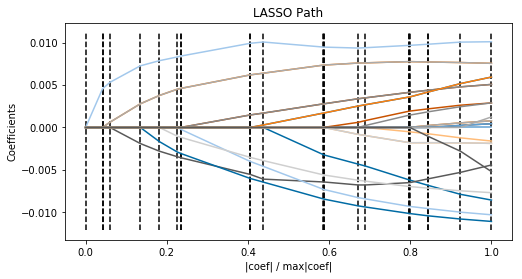

beta
Coh_diff_mag
Coh_proj
Initial_coh_sd
PC1a_sd
PC1b_sd
PC2a_mean
PC2b_mean
Both_S1
Block_num
Phase
PC2a_sd
PC2b_sd
Coh_proj_sd
Distance_to_A2
Distance_to_A1
Distance
PC1a_mean
PC1b_mean
Both_M1
Initial_coh
Delays
Distance_to_B2
Distance_to_B1


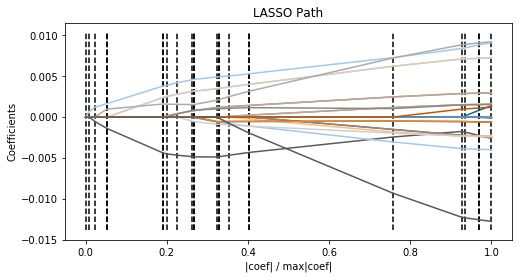

gamma
Coh_proj
Coh_proj_sd
PC2b_mean
PC2a_mean
Coh_diff_mag
Distance_to_A2
Distance_to_A1
Distance
Phase
Initial_coh_sd
PC1a_sd
PC1b_sd
Distance_to_B1
Distance_to_B2
Both_M1
Both_S1
PC2a_sd
PC2b_sd
Initial_coh
Delays
Block_num
PC1b_mean
PC1a_mean


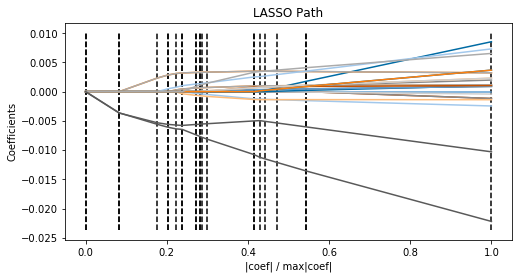

high_gamma
Coh_proj_sd
Coh_proj
Delays
Coh_diff_mag
Distance
PC2a_sd
PC2b_sd
Initial_coh
Phase
Both_S1
PC2a_mean
PC2b_mean
Block_num
Distance_to_B1
Distance_to_B2
PC1b_mean
PC1a_mean
Both_M1
PC1b_sd
PC1a_sd
Distance_to_A1
Distance_to_A2
Initial_coh_sd


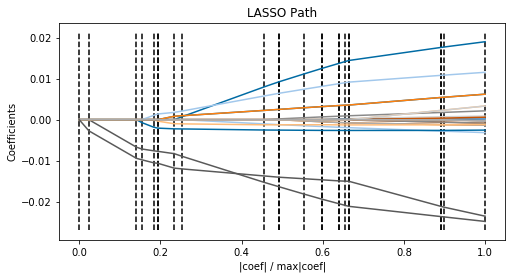

In [8]:
dm = patsy.dmatrix(formula, dataframes[band])
features = dm.design_info.column_names

for band in ["theta", "beta", "gamma", "high_gamma"]:
    print(band)
    for feature_i in active[band]:
        print(features[feature_i])
#     print()

    xx = np.sum(np.abs(coefs[band].T), axis=1)
    xx /= xx[-1]

    plt.figure(figsize=(8, 4))
    plt.plot(xx, coefs[band].T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.axis('tight')
    plt.show()

In [ ]:
# ## correlations

# for band in ["theta", "beta", "gamma", "high_gamma"]:
#     print(band)
#     x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
#     scaler = StandardScaler()
#     x = scaler.fit_transform(x)

#     dm = patsy.dmatrix(formula, dataframes[band])
#     features = dm.design_info.column_names

#     plt.figure(figsize=(10,10))
#     plt.imshow(np.cov(x, rowvar=False))
#     plt.colorbar()
#     plt.show()

In [ ]:
# features

## Lasso CV

In [9]:
# models = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
# opts = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
# for band in ["theta", "beta", "gamma", "high_gamma"]:
#     print(band)
#     x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
#     scaler = StandardScaler()
#     x = scaler.fit_transform(x)
    
#     y = dataframes[band][response].to_numpy().reshape(-1, 1)
#     scaler = StandardScaler()
#     y = scaler.fit_transform(y)
    
#     x, y = shuffle(x, y)
    
#     opt = BayesSearchCV(LassoLars(fit_intercept=False), {'alpha': Real(1e-8, .9, prior='log-uniform')},
#                         scoring="neg_mean_squared_error", cv=5, n_iter=15, fit_params={},
#                        n_jobs=4, verbose=0)
#     opt.fit(x, y)
    
#     opts[band] = opt
   

In [10]:
# for band in ["theta", "beta", "gamma", "high_gamma"]:
#     all_y_preds = []
#     all_y_true = []
    
#     x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
#     scaler = StandardScaler()
#     x = scaler.fit_transform(x)
#     y = dataframes[band][response].to_numpy().reshape(-1, 1)
#     scaler = StandardScaler()
#     y = scaler.fit_transform(y)
    
#     kfs = KFold(5, shuffle=True)
#     for i, kf in enumerate(kfs.split(x)):
#         train_index, test_index = kf
        
#         x_train = x[train_index]
#         y_train = y[train_index]
#         x_test = x[test_index]
#         y_test = y[test_index]        

#         lasso = Lasso(alpha=opts[band].best_params_['alpha']).fit(x_train, y_train)

#         all_y_preds.append(lasso.predict(x_test))
#         all_y_true.append(y_test)
                
#     all_y_preds = [item for sublist in all_y_preds for item in sublist]
#     all_y_true = [item for sublist in all_y_true for item in sublist]

#     print(band+" r2: "+str(r2_score(all_y_true, all_y_preds)))

# Linear results

In [26]:
for band in ["theta", "beta", "gamma", "high_gamma"]:
    all_y_preds = []
    all_y_true = []
    
    x = np.asarray(patsy.dmatrix(formula, dataframes[band]))
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = dataframes[band][response].to_numpy().reshape(-1, 1).flatten()
#     scaler = StandardScaler()
#     y = scaler.fit_transform(y)
    
    kfs = KFold(5, shuffle=True)
    for i, kf in enumerate(kfs.split(x)):
        train_index, test_index = kf
        
        x_train = x[train_index]
        y_train = y[train_index]
        x_test = x[test_index]
        y_test = y[test_index]        

        lm = linear_model.LinearRegression(fit_intercept=True, normalize=False).fit(x_train, y_train)

        all_y_preds.append(lm.predict(x_test))
        all_y_true.append(y_test)
                
    all_y_preds = [item for sublist in all_y_preds for item in sublist]
    all_y_true = [item for sublist in all_y_true for item in sublist]

    print(band+" r2: "+str(r2_score(all_y_true, all_y_preds)))

theta r2: 0.2709113023931714
beta r2: 0.17015366628550233
gamma r2: 0.23458428710842194
high_gamma r2: 0.36791098887126883


In [ ]:
break

## One model per session

In [ ]:
results = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

for band in ["theta", "beta", "gamma", "high_gamma"]:

    for block_key in dataframes[band]["Experiment_block_key"].unique():
        sess_df = dataframes[band].loc[dataframes[band]["Experiment_block_key"] == block_key]
    
#         print(band)
        x = np.asarray(patsy.dmatrix(formula, sess_df))
        scaler = StandardScaler()
        x = scaler.fit_transform(x)

        y = sess_df[response].to_numpy().reshape(-1, 1)
        scaler = StandardScaler()
        y = scaler.fit_transform(y)

        x, y = shuffle(x, y)

        opt = BayesSearchCV(LassoLars(fit_intercept=False, max_iter=100000), {'alpha': Real(1e-8, .9, prior='log-uniform')},
                            scoring="neg_mean_squared_error", cv=5, n_iter=12, fit_params={},
                           n_jobs=6, verbose=0)
        opt.fit(x, y)

        all_y_preds = []
        all_y_true = []

        x = np.asarray(patsy.dmatrix(formula, sess_df))
        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        y = sess_df[response].to_numpy().reshape(-1, 1)
        scaler = StandardScaler()
        y = scaler.fit_transform(y)

        kfs = KFold(5, shuffle=True)
        for i, kf in enumerate(kfs.split(x)):
            train_index, test_index = kf

            x_train = x[train_index]
            y_train = y[train_index]
            x_test = x[test_index]
            y_test = y[test_index]        

            lasso = Lasso(alpha=opt.best_params_['alpha'], max_iter=100000).fit(x_train, y_train)

            all_y_preds.append(lasso.predict(x_test))
            all_y_true.append(y_test)

        all_y_preds = [item for sublist in all_y_preds for item in sublist]
        all_y_true = [item for sublist in all_y_true for item in sublist]

        print(band+" r2: "+str(r2_score(all_y_true, all_y_preds)))
        
        results[band].append(r2_score(all_y_true, all_y_preds))

In [ ]:
results

In [ ]:
for band in results:
    print(band)
    print(np.mean(results[band]))
    print(np.std(results[band]))

## Leave-one-session-out CV

In [ ]:
results = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
coefs = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

for band in ["theta", "beta", "gamma", "high_gamma"]:

    for block_key in dataframes[band]["Experiment_block_key"].unique():
        sess_df = dataframes[band].loc[dataframes[band]["Experiment_block_key"] != block_key]
    
#         print(band)
        x = np.asarray(patsy.dmatrix(formula, sess_df))
        x_scaler = StandardScaler()
        x = x_scaler.fit_transform(x)

        y = sess_df[response].to_numpy().reshape(-1, 1)
        y_scaler = StandardScaler()
        y = y_scaler.fit_transform(y)

        x, y = shuffle(x, y)

        opt = BayesSearchCV(LassoLars(fit_intercept=False, max_iter=100000), {'alpha': Real(1e-8, .9, prior='log-uniform')},
                            scoring="neg_mean_squared_error", cv=5, n_iter=12, fit_params={},
                           n_jobs=6, verbose=0)
        opt.fit(x, y)
        lasso = Lasso(alpha=opt.best_params_['alpha'], max_iter=100000).fit(x, y)

        test_df = dataframes[band].loc[dataframes[band]["Experiment_block_key"] == block_key]
        test_x = np.asarray(patsy.dmatrix(formula, test_df))
        test_x = x_scaler.fit_transform(test_x)
        test_y = test_df[response].to_numpy().reshape(-1, 1)
        test_y = y_scaler.fit_transform(test_y)
        
#         lasso = Lasso(alpha=opt.best_params_['alpha'], max_iter=100000).fit(test_x, test_y)
        result = r2_score(test_y, lasso.predict(test_x))
        
        print(band+" r2: "+str(result))
        
        results[band].append(result)
        coefs[band].append(lasso.coef_)

In [ ]:
for band in results:
    print(band)
    print(np.mean(results[band]))
    print(np.std(results[band]))
    print()

In [ ]:
from sklearn import neighbors

results = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}
coefs = {"theta":[], "beta":[], "gamma":[], "high_gamma":[]}

for band in ["theta", "beta", "gamma", "high_gamma"]:

    for block_key in dataframes[band]["Experiment_block_key"].unique():
        sess_df = dataframes[band].loc[dataframes[band]["Experiment_block_key"] != block_key]
    
#         print(band)
        x = np.asarray(patsy.dmatrix(formula, sess_df))
        x_scaler = StandardScaler()
        x = x_scaler.fit_transform(x)

        y = sess_df[response].to_numpy().reshape(-1, 1)
        y_scaler = StandardScaler()
        y = y_scaler.fit_transform(y)

        x, y = shuffle(x, y)

        
        # KNN parameters
        knn = neighbors.KNeighborsRegressor(15, weights='uniform')
        knn_model = knn.fit(x, y)


        test_df = dataframes[band].loc[dataframes[band]["Experiment_block_key"] == block_key]
        test_x = np.asarray(patsy.dmatrix(formula, test_df))
        test_x = x_scaler.fit_transform(test_x)
        test_y = test_df[response].to_numpy().reshape(-1, 1)
        test_y = y_scaler.fit_transform(test_y)
        print("here")
#         lasso = Lasso(alpha=opt.best_params_['alpha'], max_iter=100000).fit(test_x, test_y)
        result = r2_score(test_y, knn_model.predict(test_x))
        
        print(band+" r2: "+str(result))
        
        results[band].append(result)
#         coefs[band].append(lasso.coef_)